# Recolhendo os dados

## Importações

In [1]:
from nltk import word_tokenize
import nltk
import re
import tweepy as tw
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

## Acessando API do Twitter

Lendo arquivo .txt com as chaves para acessar a API do Twitter e em seguida acessando a API.

In [3]:
with open('twitter-tokens.txt','r') as tfile:
    consumer_key = tfile.readline().strip('\n')
    consumer_secret = tfile.readline().strip('\n')
    access_token = tfile.readline().strip('\n')
    access_token_secret = tfile.readline().strip('\n')

In [4]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tw.API(auth)

## Recuperando os Tweets

Definindo os termos de buscas, idioma e quantidade dos tweets recuperados assim como filtrando para não recuperar retweets.

In [5]:
query_search = 'covid' + '-filter:retweets'

cursor_tweets = tw.Cursor(api.search,
                  q=query_search,
                  lang='pt',tweet_mode='extended').items(100)

Recuperando o dicionário previamente criado com o as informações que serão recolhidas dos tweets recuperados.

In [6]:
tweets_dict = {'full_text':[]}

Recuperando os tweets através do cursor criado anteriormente e salvando-as no dicionário.

In [7]:
for tweet in cursor_tweets:
    for key in tweets_dict.keys():
        try:
            # para cada tweet recuperado tenta salva-lo no dicíonario em sua respectiva chave
            tw_from_key = tweet._json[key]
            # usa expressão regular para remover links dos tweets
            if key == 'full_text':
                tw_from_key = re.sub(r"http\S+", "", tw_from_key)
                tw_from_key = re.sub(r"@\S+", "", tw_from_key)
            tweets_dict[key].append(tw_from_key)
        except KeyError:
            # caso algum tweet recuperado não tenha algum dos dados procurados adiciona uma string vazia
            tw_from_key = ''
            tweets_dict[key].append('')        

Salvando os dados do dicionário em um dataframe.

In [8]:
tw_df = pd.DataFrame.from_dict(tweets_dict)
tw_df

,full_text
0,A CUFA está em todo território nacional e em ...
1,a segunda onda de covid tá vindo
2,Meus vizinhos encontraram a cura pro Covid e e...
3,"Papa Francisco disse que ""fofocar é uma praga..."
4,Nem na quarentena fiquei sem sol. Por isso ac...
...,...
95,A CUFA está em todo território nacional e em ...
96,Os casos de covid estão aumentando na Croáci...
97,lá não tem covid.....
98,"""pandemia comunista"", ""ditadura do covid"", ""in..."


Salvando os tweets em um arquivo .csv

In [9]:
tw_df.to_csv('tweet_data.csv')

In [2]:
df = pd.read_csv('tweet_data_clf.csv',index_col=0)
df.head()

,full_text,sentiment
0,A CUFA está em todo território nacional e em ...,2
1,a segunda onda de covid tá vindo,2
2,Meus vizinhos encontraram a cura pro Covid e e...,1
3,"Papa Francisco disse que ""fofocar é uma praga...",2
4,Nem na quarentena fiquei sem sol. Por isso ac...,3


Os tweets foram classificados da seguinte maneira:
    1->negativo,
    2->neutro,
    3->positivo.

In [3]:
df.sentiment.value_counts()

1    56
2    40
3     4
Name: sentiment, dtype: int64

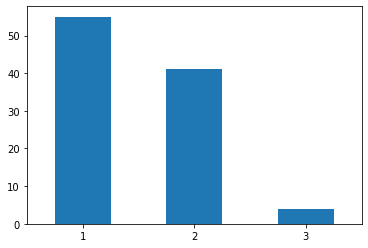

In [153]:
df.sentiment.value_counts().plot(kind='bar')
locs, labels = plt.xticks()
plt.setp(labels, rotation=0);

Podemos ver um grande desbalanceamento entre a categoria positiva e as demais.

# Pré-Processamento dos Dados

#### Removendo Tweets duplicados

Ainda que na coleta dos dados tenham sido filtrados os retweets ainda assim foram recolhidos alguns tweets duplicados.

In [154]:
df.full_text.count()

100

In [155]:
df.drop_duplicates(['full_text'], inplace=True)
df.full_text.count()

97

#### Separando teste e treino.

In [156]:
from sklearn.model_selection import train_test_split

In [157]:
train_set, test_set = train_test_split(df,test_size=0.2,random_state=42)

#### Separando predictors e labels.

In [158]:
tweets = train_set.drop('sentiment',axis=1)
classe = train_set['sentiment'].copy()

#### Criando função que irá pré-processar o texto.

In [135]:
def Preprocessing(instancia):
    # Remove caracteres indesejados.
    instancia = instancia.lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','').replace('"','').replace(',','')
    # Removendo palavras e termos frequentes que não tem relevância nos dados.
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

In [159]:
tweets = [Preprocessing(i) for i in tweets.full_text]

In [160]:
print('''Antes: {}

Depois: {}'''.format(train_set.full_text.iloc[0],tweets[0]))

Antes: Manos por favor, COVID não tem uma cláusula assinada na qual ele infectará o indivíduo APENAS se na reunião houver mais de 5 pessoas
Vejo gente criticando o bar até virar do avesso e reunindo com 4 pessoas que não moram c ela.

Aglomeração é mais questão de chance de contágio Zé

Depois: manos favor covid cláusula assinada infectará indivíduo apenas reunião 5 pessoas vejo gente criticando bar virar avesso reunindo 4 pessoas moram c aglomeração questão chance contágio zé


#### Tokenização

Usando a biblioteca nltk para tokenizar os tweets. Ou seja, dividir uma string ou textos em uma lista de tokens.

In [161]:
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer() 
tweet_tokenizer.tokenize(tweets[0])

['manos',
 'favor',
 'covid',
 'cláusula',
 'assinada',
 'infectará',
 'indivíduo',
 'apenas',
 'reunião',
 '5',
 'pessoas',
 'vejo',
 'gente',
 'criticando',
 'bar',
 'virar',
 'avesso',
 'reunindo',
 '4',
 'pessoas',
 'moram',
 'c',
 'aglomeração',
 'questão',
 'chance',
 'contágio',
 'zé']

In [139]:
# Instanciando o objeto que faz a vetorização dos dados de texto.
vectorizer = CountVectorizer(analyzer="word", tokenizer=tweet_tokenizer.tokenize)

In [140]:
# Aplica o vetorizador nos dados de texto e retorna uma matriz esparsa:
freq_tweets = vectorizer.fit_transform(tweets)

Treinando um modelo de Naive Bayes

In [141]:
# Treino de modelo de Machine Learning:
modelo = MultinomialNB()
modelo.fit(freq_tweets,classe)

MultinomialNB()

Testando com alguns tweets do set de teste.

In [166]:
testes = list(test_set.iloc[1:4].full_text)
testes

[' Suspeita de covid more',
 '  Os casos de covid estão aumentando na Croácia. Rezando pra lenda não pegar 🙌🏽🙌🏽😭',
 'Tem umas pessoas que eu olho os storys e fico pensando COMO que nao pegou covid ainda????????']

In [167]:
# Transforma os dados de teste em vetores de palavras:
freq_testes = vectorizer.transform(testes)

In [176]:
# Fazendo a classificação com o modelo treinado:
for t,p, c in zip (testes,modelo.predict(freq_testes),test_set.iloc[1:4].sentiment):
    # t representa o tweet e p a predição de cada tweet e c a classifição humana.
    print ('''Tweet: {}
           Predição: {}
           Classificação humana: {}'''.format(t, c,p)) 

Tweet:  Suspeita de covid more
           Predição: 1
           Classificação humana: 1
Tweet:   Os casos de covid estão aumentando na Croácia. Rezando pra lenda não pegar 🙌🏽🙌🏽😭
           Predição: 1
           Classificação humana: 1
Tweet: Tem umas pessoas que eu olho os storys e fico pensando COMO que nao pegou covid ainda????????
           Predição: 2
           Classificação humana: 1


In [186]:
# Medindo a acurácia média do modelo:
teste_tweets = [Preprocessing(i) for i in test_set.full_text]
freq_teste_tweets = vectorizer.transform(teste_tweets)

resultados = modelo.predict(freq_teste_tweets)
classes = test_set.sentiment

metrics.accuracy_score(classes,resultados)

0.6

In [189]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   1  2  All
Real               
1         9  2   11
2         5  3    8
3         1  0    1
All      15  5   20


In [188]:
# Medidas de validação do modelo:
sentimento=['Positivo','Negativo','Neutro']
print (metrics.classification_report(classes,resultados))

              precision    recall  f1-score   support

           1       0.60      0.82      0.69        11
           2       0.60      0.38      0.46         8
           3       0.00      0.00      0.00         1

    accuracy                           0.60        20
   macro avg       0.40      0.40      0.38        20
weighted avg       0.57      0.60      0.57        20



C:\Users\joaoa\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
